# Analysis of importance of the features for predicting presence or absence of protein.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv("yeast2vs4.csv")
first_col = np.array(df["mcg"])
print("minimum_value of first column: ", np.min(first_col))

# Preprocess data
x=df.iloc[:,:-1].values # convert to numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_x_scaled = pd.DataFrame(x_scaled)
df_x_scaled.head()

df_scaled = pd.concat([df_x_scaled, df.iloc[:,-1]], axis=1)
df_scaled = df_scaled.replace(["negative", "positive"], [-1,1])
df_scaled.head()

minimum_value of first column:  0.19


,0,1,2,3,4,5,6,7,class
0,0.410256,0.275362,0.397260,0.17,0.0,1.0,0.600000,0.2750,-1
1,0.269231,0.260870,0.452055,0.15,0.0,0.0,0.750000,0.3750,-1
2,0.269231,0.304348,0.410959,0.35,0.0,0.0,0.666667,0.3125,-1
3,0.346154,0.333333,0.342466,0.11,0.0,0.0,0.616667,0.2750,-1
4,0.358974,0.260870,0.315068,0.11,0.0,0.0,0.600000,0.5000,-1


In [2]:
print("Total number of samples: ", len(df_scaled))
print("df_scaled: ", df_x_scaled)
print(" Number of samples:")
print(df.iloc[:,-1].value_counts())

Total number of samples:  514
df_scaled:              0         1         2     3    4    5         6       7
0    0.410256  0.275362  0.397260  0.17  0.0  1.0  0.600000  0.2750
1    0.269231  0.260870  0.452055  0.15  0.0  0.0  0.750000  0.3750
2    0.269231  0.304348  0.410959  0.35  0.0  0.0  0.666667  0.3125
3    0.346154  0.333333  0.342466  0.11  0.0  0.0  0.616667  0.2750
4    0.358974  0.260870  0.315068  0.11  0.0  0.0  0.600000  0.5000
..        ...       ...       ...   ...  ...  ...       ...     ...
509  0.794872  1.000000  0.164384  0.41  0.0  0.0  0.666667  0.2750
510  0.820513  0.463768  0.342466  0.20  0.0  0.0  0.583333  0.3125
511  0.756410  0.391304  0.273973  0.30  0.0  0.0  0.666667  0.5875
512  0.679487  0.507246  0.178082  0.26  0.0  0.0  0.633333  0.3250
513  0.615385  0.521739  0.123288  0.19  0.0  0.0  0.716667  0.2750

[514 rows x 8 columns]
 Number of samples:
negative    463
positive     51
Name: class, dtype: int64


In [3]:
correlation_matrix = df_scaled.corr()

# get column names
column_names=[]
for col in df:
    column_names.append(col)
print("column names: ", column_names)

column names:  ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class']


2. Creation of KNN, SVM and decision tree model to predict presence or absence of protein

In [4]:
# split dataset into training, validation and test set
from sklearn.model_selection import train_test_split

X = df_scaled.iloc[:,:-1]
y = df_scaled.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.8*0.25=0.2


In [5]:
# Classification with SVM
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from matplotlib import pyplot as plt


C_s = 2.0**np.arange(-7, 20, 1)
kernels = ["linear", "poly", "rbf", "sigmoid"]
clf_c_ker = []
clf_c = []
y_pred_c = []
accuracies = np.empty((len(C_s), len(kernels)))
g_means = np.empty((len(C_s), len(kernels)))
y_pred_s = [] 
for j in range(0, len(kernels)):
    for i in range(0, len(C_s)):
        clf = svm.SVC(C=C_s[i], kernel=kernels[j])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        g_mean = geometric_mean_score(y_val, y_pred)
        #print("C= {}, kernel={}  : accuracy={}%".format(C_s[i], kernels[j], np.round(accuracy*100,decimals=2)))

        clf_c.append(clf)
        y_pred_c.append(y_pred)
        accuracies[i,j] = accuracy
        g_means[i,j] = g_mean
    clf_c_ker.append(clf_c)
    y_pred_s.append(y_pred_c)

# Print Optimal result
optimal_index = np.unravel_index(np.argmax(g_means), g_means.shape)
optimal_c = C_s[optimal_index[0]]
optimal_kernel = kernels[optimal_index[1]]
conf_matr = confusion_matrix(y_val, y_pred_s[optimal_index[1]][optimal_index[0]])
print("Optimal g-mean: {:.3f}".format(g_means[optimal_index]))
print("Corresponding accuracy: {:.3f}".format(accuracies[optimal_index]))
print("Optimal C regarding g-mean: {}".format(optimal_c))
print("Optimal kernel regarding g-mean: {}".format(optimal_kernel))
print("Confusion matrix of optimal parameters: ")
print(conf_matr)

# Create plot for G-mean
fig, ax = plt.subplots(1,1, figsize=(15,5))
graphic = plt.imshow(np.transpose(g_means), cmap="viridis", interpolation='nearest', aspect='2.0')
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('G-mean')
for (j,i),label in np.ndenumerate(np.transpose(g_means)):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(kernels)
ax.set_yticks([0,1,2,3])
ax.set_xticks(np.arange(0,len(C_s)))
ax.set_xticklabels(C_s.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('C')
plt.title("G-mean of SVM for different settings")
plt.legend()


# Create plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(15,5))
graphic = plt.imshow(np.transpose(accuracies), cmap="viridis", interpolation='nearest', aspect="2.0")
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('Accuracy')
for (j,i),label in np.ndenumerate(np.transpose(accuracies)):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(kernels)
ax.set_yticks([0,1,2,3])
ax.set_xticks(np.arange(0,len(C_s)))
ax.set_xticklabels(C_s.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('C')
plt.title("Accuracy of SVM for different settings")
plt.legend()

ModuleNotFoundError: No module named 'imblearn'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal g-mean: 0.786
Corresponding accuracy: 0.961
Optimal k regarding g-means: 13
Optimal weight regarding g-means: uniform
Confusion matrix of optimal parameters: 
[[93  2]
 [ 2  6]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


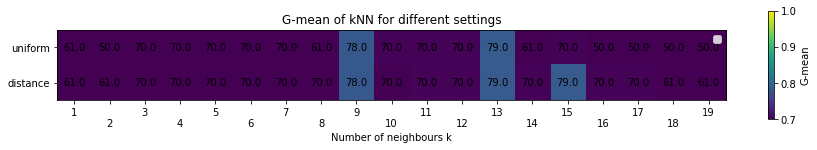

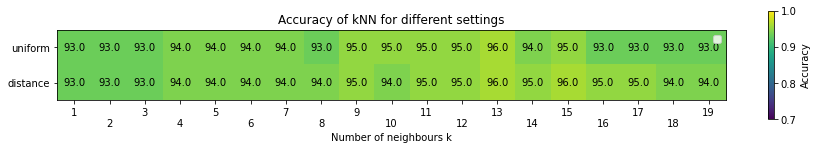

In [ ]:
# Classification with knn
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings("ignore")


ks = np.arange(1,20)
weights = ["uniform", "distance"]
clf_all = []
y_pred_all = []
clf_uni = []
clf_wei = []
y_pred_uni = []
y_pred_wei = []
accuracies = np.empty((len(ks), len(weights)))
g_means = np.empty((len(ks), len(weights)))
 
for j in range(0, len(weights)):
    for i in range(0, len(ks)):
        clf = KNeighborsClassifier(n_neighbors=ks[i], weights=weights[j])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        g_mean = geometric_mean_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        #print("k= {}, weight={}  : accuracy={}%".format(ks[i], weights[j], np.round(accuracy*100,decimals=2)))
        if j==0:
            clf_uni.append(clf)
            y_pred_uni.append(y_pred)
        elif j==1:
            clf_wei.append(clf)
            y_pred_wei.append(y_pred)
        accuracies[i,j] = accuracy
        g_means[i,j] = g_mean
y_pred_all=[y_pred_uni, y_pred_wei]
clf_all=[clf_uni, clf_wei]


optimal_index = np.unravel_index(np.argmax(g_means), g_means.shape)
optimal_k = ks[optimal_index[0]]
optimal_weight = weights[optimal_index[1]]
conf_matr = confusion_matrix(y_val, y_pred_s[optimal_index[1]][optimal_index[0]])
print("Optimal g-mean: {:.3f}".format(g_means[optimal_index]))
print("Corresponding accuracy: {:.3f}".format(accuracies[optimal_index]))
print("Optimal k regarding g-means: {}".format(optimal_k))
print("Optimal weight regarding g-means: {}".format(optimal_weight))
print("Confusion matrix of optimal parameters: ")
print(conf_matr)


# Create plot for G-mean
fig, ax = plt.subplots(1,1, figsize=(15,2))
graphic = plt.imshow(np.transpose(g_means), cmap="viridis", interpolation='nearest')
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('G-mean')
for (j,i),label in np.ndenumerate(np.transpose(g_means)):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(weights)
ax.set_yticks([0,1])
ax.set_xticks(np.arange(0,len(ks)))
ax.set_xticklabels(ks.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('Number of neighbours k')
plt.title("G-mean of kNN for different settings")
plt.legend()


# Create plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(15,2))
graphic = plt.imshow(np.transpose(accuracies), cmap="viridis", interpolation='nearest')
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('Accuracy')
for (j,i),label in np.ndenumerate(np.transpose(accuracies)):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(weights)
ax.set_yticks([0,1])
ax.set_xticks(np.arange(0,len(ks)))
ax.set_xticklabels(ks.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('Number of neighbours k')
plt.title("Accuracy of kNN for different settings")
plt.legend()


Optimal g-mean: 0.782
Corresponding accuracy: 0.951
Optimal criterion regarding g-mean: gini
Optimal min number of samples per leaf regarding g-mean: 5
Confusion matrix of optimal parameters: 
[[89  6]
 [ 3  5]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


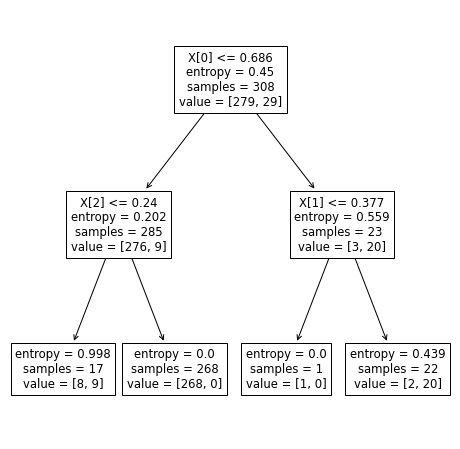

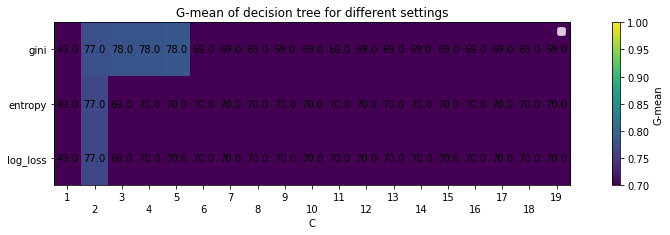

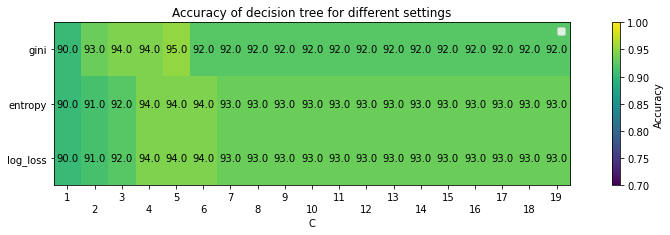

In [ ]:
# Classification with decision trees

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn import tree
import graphviz

criteria = ["gini", "entropy", "log_loss"]
min_samples_leafs=np.arange(1,20)

clf_all = []
clf_crit = []
y_pred_crit = []
y_pred_all = []
accuracies = np.empty((len(criteria), len(min_samples_leafs)))
g_means = np.empty((len(criteria), len(min_samples_leafs)))

for j in range(0, len(min_samples_leafs)):
    for i in range(0, len(criteria)):
        clf = tree.DecisionTreeClassifier(criterion=criteria[i], max_depth=min_samples_leafs[j], random_state=1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        g_mean = geometric_mean_score(y_val, y_pred)
        #print("Criterion= {}, min_samples_leaf={}  : accuracy={}%".format(criteria[i], min_samples_leafs[j], np.round(accuracy*100,decimals=2)))

        clf_crit.append(clf)
        y_pred_crit.append(y_pred)
        accuracies[i,j] = accuracy
        g_means[i,j] = g_mean
    clf_all.append(clf_crit)
    y_pred_all.append(y_pred_crit)



# Print Optimal result
optimal_index = np.unravel_index(np.argmax(g_means), g_means.shape)
optimal_crit = criteria[optimal_index[0]]
optimal_msl = min_samples_leafs[optimal_index[1]]
conf_matr = confusion_matrix(y_val, y_pred_all[optimal_index[0]][optimal_index[1]])
print("Optimal g-mean: {:.3f}".format(g_means[optimal_index]))
print("Corresponding accuracy: {:.3f}".format(accuracies[optimal_index]))
print("Optimal criterion regarding g-mean: {}".format(optimal_crit))
print("Optimal min number of samples per leaf regarding g-mean: {}".format(optimal_msl))
print("Confusion matrix of optimal parameters: ")
print(conf_matr)

# Plot optimal tree
plt.figure(figsize=(8,8)) 
tree.plot_tree(clf_all[optimal_index[0]][optimal_index[1]])
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)  
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=df.columns[:-1],  
                     class_names=["positive", "negative"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  


# Create plot for G-mean
fig, ax = plt.subplots(1,1, figsize=(15,3))
graphic = plt.imshow(g_means, cmap="viridis", interpolation='nearest', aspect='2.0')
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('G-mean')
for (j,i),label in np.ndenumerate(g_means):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(criteria)
ax.set_yticks([0,1,2])
ax.set_xticks(np.arange(0,len(min_samples_leafs)))
ax.set_xticklabels(min_samples_leafs.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('C')
plt.title("G-mean of decision tree for different settings")
plt.legend()


# Create plot for accuracy
fig, ax = plt.subplots(1,1, figsize=(15,3))
graphic = plt.imshow(accuracies, cmap="viridis", interpolation='nearest', aspect="2.0")
# make colorbar
cbar = fig.colorbar(graphic) 
cbar.set_label('Accuracy')
for (j,i),label in np.ndenumerate(accuracies):
    ax.text(i,j,np.round(label*100),ha='center',va='center')
plt.clim(0.7,1.0)
# Set ticks and labels of axes
ax.set_yticklabels(criteria)
ax.set_yticks([0,1,2])
ax.set_xticks(np.arange(0,len(min_samples_leafs)))
ax.set_xticklabels(min_samples_leafs.astype(str))
ax.tick_params(axis='x', which='minor', labelsize=8)
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(15)
plt.xlabel('C')
plt.title("Accuracy of decision tree for different settings")
plt.legend()


In [ ]:
# test optimal classifiers
clf_svm = svm.SVC(C=64.0, kernel="linear")
clf_knn = KNeighborsClassifier(n_neighbors=13, weights="uniform")
clf_dt = tree.DecisionTreeClassifier(criterion="gini", max_depth=6)

def compute_scores(clf, X_groundtruth, y_groundtruth):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_groundtruth)
    accuracy = accuracy_score(y_groundtruth, y_pred)
    g_mean = geometric_mean_score(y_groundtruth, y_pred)
    conf_matr = confusion_matrix(y_groundtruth, y_pred)
    return g_mean, accuracy, conf_matr

def show_result(X, y, traintest):
    g_mean_svm, accuracy_svm, conf_matr_svm = compute_scores(clf_svm, X, y)
    g_mean_knn, accuracy_knn, conf_matr_knn = compute_scores(clf_knn, X, y)
    g_mean_dt, accuracy_dt, conf_matr_dt = compute_scores(clf_dt, X, y) 
    print("Test algorithm with optimized parameters on the {} set: ".format(traintest))
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("SVM", g_mean_svm, accuracy_svm))
    print("confusion matrix: ")
    print(conf_matr_svm)
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("KNN", g_mean_knn, accuracy_knn))
    print("confusion matrix: ")
    print(conf_matr_knn)
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("DT", g_mean_dt, accuracy_dt))
    print("confusion matrix: ")
    print(conf_matr_dt)

show_result(X_train, y_train, "training")
print(" ")
show_result(X_test, y_test, "test")

Test algorithm with optimized parameters on the training set: 
Algoritm: SVM  geometric mean: 0.879  accuracy: 0.958
confusion matrix: 
[[272   7]
 [  6  23]]
Algoritm: KNN  geometric mean: 0.785  accuracy: 0.958
confusion matrix: 
[[277   2]
 [ 11  18]]
Algoritm: DT  geometric mean: 1.000  accuracy: 1.000
confusion matrix: 
[[279   0]
 [  0  29]]
 
Test algorithm with optimized parameters on the test set: 
Algoritm: SVM  geometric mean: 0.881  accuracy: 0.961
confusion matrix: 
[[88  1]
 [ 3 11]]
Algoritm: KNN  geometric mean: 0.756  accuracy: 0.942
confusion matrix: 
[[89  0]
 [ 6  8]]
Algoritm: DT  geometric mean: 0.797  accuracy: 0.942
confusion matrix: 
[[88  1]
 [ 5  9]]


### Result of validation:

SVM:

    Optimal g-mean: 0.8614553169827758
    Corresponding accuracy: 0.970873786407767
    Optimal C regarding g-mean: 64.0
    Optimal kernel regarding g-mean: linear
    Confusion matrix of optimal parameters: 

    [[94  1]
    
    [ 2  6]]

KNN:

    Optimal g-mean: 0.7863975156570492
    Corresponding accuracy: 0.9611650485436893
    Optimal k regarding g-means: 13
    Optimal weight regarding g-means: uniform
    Confusion matrix of optimal parameters: 

    [[93  2]

    [ 2  6]]

Decision tree:

    Optimal g-mean: 0.7822033656685184
    Corresponding accuracy: 0.9514563106796117
    Optimal criterion regarding g-mean: gini
    Optimal min number of samples per leaf regarding g-mean: 5
    Confusion matrix of optimal parameters: 

    [[89  6]

    [ 3  5]]

Result of testing:

    Algoritm: SVM  geometric mean: 0.8814113882365042  
    accuracy: 0.9611650485436893
    confusion matrix: 

    [[88  1]

    [ 3 11]]

    Algoritm: KNN  
    geometric mean: 0.7559289460184544  
    accuracy: 0.941747572815534
    confusion matrix: 

    [[89  0]

    [ 6  8]]

    Algoritm: DT  
    geometric mean: 0.7972665983800249  
    accuracy: 0.941747572815534
    confusion matrix: 

    [[88  1]

    [ 5  9]]

 Since the dataset is highly inbalanced (more than 90% of the samples belong to the class "negative" and less than 10% to the class "negative"), the geometric mean is chosen as an evaluation metric. Nevertheless, the accuracy is also observed because it is more easily interpretable in an intuitive manner compared to the geometric mean. 
 The accuracy and geometric means for SVM and KNN are similar for the training as well as the test set. Consequently, there should not be overfitting. However, the classification for decision trees is perfect on the training set and significantly worse on the test set. Therefore, it is extremly likely that overfitting occured. To reduce the likelihood of overfitting the minimum number of leaf samples could be increased or the maximum depth of the tree could be reduced. Both method were uses although only one can be seen in the code. These approaches however lead to worse geometric means and accuracies on the validation set. 

 To tackle overfitting, the decision tree could be prune where information gain is lowest. Alternatively, bagging (bootstrapp aggregating) or AdaBoost could be used. However, those method belong to the group of ensemble learning methods and, therefore, are beyond of the scope of this task. 

### Explanation for eachdesign decision for each ML model:

Every method was tested with several different combinations of "modes" and values for hyperparameters. For instance, SVM was tested with different kernels and C-values. By doing so, a wide range of adjustments were tested with the validation set. The combination of modes and hyperparameter value that lead to the smallest geometric error was chosen. This approach was chosen for every ML model to make sure to get the best overall performance of each individual model. Finally, the test set was used to check for overfitting. Thereby, only decision trees seemed to overfit. 

### Here overview of the optimised hyper-parameters:

    SVM: C, kernel
    KNN: number of closest neigbours k, uniform weigting of neighbours or distance based weighting
    DT: Optimization cirterion, maximal depth of tree

SVM:
Depending on the structure of the data, some kernels can better separate the data than others. Therefore, different kernels were tested.
If the datapoints of the training set are very noisy, you might want to trust them less and chose a small C. Otherwise, a large C is better because you can trust your training data more and exploit its information more intensively. Therefore C was optimized.

KNN:
The smaller the number of considered neighbours (k), the more complex the decision boundary and the higher the risk of overfitting. However, a high k can lead to always classify a new sample as the major class in higly unbalanced datasets. Moverover, the risk of overfitting is higher with a high k. The tradeoff between overfitting and underfitting can be made by choosing k which is why it's variation was considered.
Weighting the importance of samples close to the new sample can make classification more precise. However, additional computational costs are involved with it. In order to check if the weighting with the inverse distance improves g-mean, both weighting methods were checked.

DT:
Choosing different optimization criteria was done to explore which effect they have on the quality of classification. The maximum depth of the tree was varied to avoid overfitting. A small maximum depth can do this quite well. 

### Final recommendations:

SVM has by far the highest geometric accuracy compared to KNN and DT on the test set which is why I would recommend to use SVM. Although, KNN did not seem to overfit it nearly misclassified half of the minor class. Decision trees not only performed as bad as KNN for it's best hyper-parameters on the validation set. It also overfitted for these hyper-parameters. To conclude, SVM with C=64 and a linear kernel is recommended.

# Three ensemble models for predicting presence or absence of protein

In [ ]:
# define functions
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score

def train_classifier(classifier_name, hyper_par1, hyper_par2):
    accuracies = np.empty((len(hyper_par1), len(hyper_par2)))
    g_means = np.empty((len(hyper_par1), len(hyper_par2)))
    clf_all = []
    y_pred_all = []
    clf_part = []
    y_pred_part = []

    for j in range(0, len(hyper_par2)):
        for i in range(0, len(hyper_par1)):
            if classifier_name=="RandomForestClassifier":
                clf = RandomForestClassifier(n_estimators=hyper_par1[i], max_leaf_nodes=hyper_par2[j], random_state=1)
            elif classifier_name=="AdaBoostClassifier":
                clf = AdaBoostClassifier(n_estimators=hyper_par1[i], learning_rate=hyper_par2[j], random_state=1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            g_mean = geometric_mean_score(y_val, y_pred)
            #print("Criterion= {}, min_samples_leaf={}  : accuracy={}%".format(criteria[i], min_samples_leafs[j], np.round(accuracy*100,decimals=2)))
            clf_part.append(clf)
            y_pred_part.append(y_pred)
            accuracies[i,j] = accuracy
            g_means[i,j] = g_mean
        clf_all.append(clf_part)
        y_pred_all.append(y_pred_part)
    return clf_all, y_pred_all, g_means, accuracies

# Print Optimal result
def print_optimal_metric(hyper1_name, hyper2_name, hyper_par1, hyper_par2):
    optimal_index = np.unravel_index(np.argmax(g_means), g_means.shape)
    optimal_hyper1 = hyper_par1[optimal_index[0]]
    optimal_hyper2 = hyper_par2[optimal_index[1]]
    conf_matr = confusion_matrix(y_val, y_pred_all[optimal_index[0]][optimal_index[1]])
    print("Optimal g-mean: {:.3f}".format(g_means[optimal_index]))
    print("Corresponding accuracy: {:.3f}".format(accuracies[optimal_index]))
    print("Optimal {} regarding g-mean: {}".format(hyper2_name, optimal_hyper1))
    print("Optimal {} regarding g-mean: {}".format(hyper1_name, optimal_hyper2))
    print("Confusion matrix of optimal parameters: ")
    print(conf_matr)

def plot_metric(metric, metric_name, p1_name, p2_name, hyper_par1, hyper_par2):
    # Create plot for G-mean
    fig, ax = plt.subplots(1,1, figsize=(15,3))
    graphic = plt.imshow(np.transpose(metric), cmap="viridis", interpolation='nearest', aspect='0.5')
    # make colorbar
    cbar = fig.colorbar(graphic) 
    cbar.set_label(metric_name)
    for (j,i),label in np.ndenumerate(np.transpose(metric)):
        ax.text(i,j,np.round(label*100),ha='center',va='center')
    plt.clim(0.7,1.0)
    # Set ticks and labels of axes
    ax.set_yticks(np.arange(0,len(hyper_par2)))
    ax.set_yticklabels(["%.2f" % mdepth for mdepth in hyper_par2])
    ax.set_xticks(np.arange(0,len(hyper_par1)))
    ax.set_xticklabels(["%.2f" % number for number in hyper_par1])
    ax.tick_params(axis='y', which='minor', labelsize=8)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    plt.xlabel(p1_name)
    plt.ylabel(p2_name)
    plt.title("{} of random forest for different settings".format(metric_name))
    plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal g-mean: 0.791
Corresponding accuracy: 0.971
Optimal number of estimator regarding g-mean: 100
Optimal maximum depth regarding g-mean: 5
Confusion matrix of optimal parameters: 
[[94  1]
 [ 8  0]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


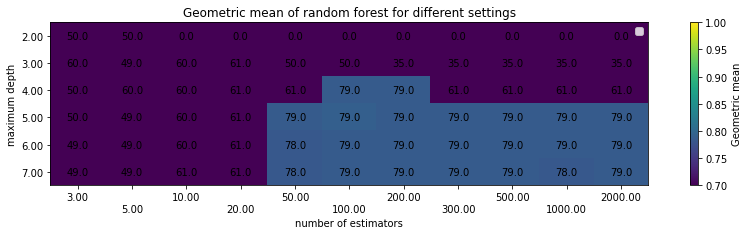

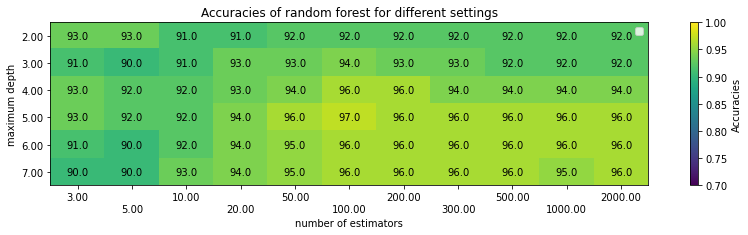

In [ ]:
# train random forest classifier

# n_estimators:
hyper_par1 = [3, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 2000]
# max_depth:
hyper_par2 = [2, 3, 4, 5, 6, 7]

clf_all, y_pred_all, g_means, accuracies = train_classifier("RandomForestClassifier", hyper_par1, hyper_par2)
print_optimal_metric("maximum depth","number of estimator", hyper_par1, hyper_par2)
plot_metric(g_means, "Geometric mean", "number of estimators", "maximum depth", hyper_par1, hyper_par2)
plot_metric(accuracies, "Accuracies", "number of estimators", "maximum depth", hyper_par1, hyper_par2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal g-mean: 0.791
Corresponding accuracy: 0.971
Optimal number of estimator regarding g-mean: 5
Optimal learning rate regarding g-mean: 0.5
Confusion matrix of optimal parameters: 
[[91  4]
 [ 6  2]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


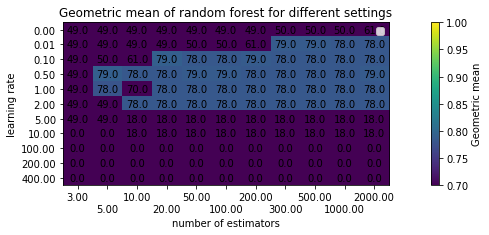

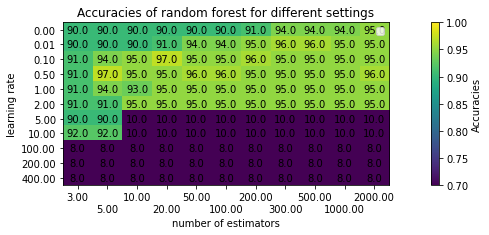

In [ ]:
# Train Ada boost

from sklearn.ensemble import AdaBoostClassifier

# n_estimators:
hyper_par1 = [3, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 2000]
# max_depth:
hyper_par2 = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 200, 400]

clf_all, y_pred_all, g_means, accuracies = train_classifier("AdaBoostClassifier", hyper_par1, hyper_par2)
print_optimal_metric("learning rate", "number of estimator", hyper_par1, hyper_par2)
plot_metric(g_means, "Geometric mean", "number of estimators", "learning rate", hyper_par1, hyper_par2)
plot_metric(accuracies, "Accuracies", "number of estimators", "learning rate", hyper_par1, hyper_par2)




In [ ]:
# Train one Perceptron
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3, random_state=1, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
g_mean = geometric_mean_score(y_pred, y_val)
accuracy = accuracy_score(y_pred, y_val)
print("geometric mean: ", g_mean)
print("accuracy: ", accuracy)
conf_matr = confusion_matrix(y_val, y_pred)
print("confustion matrix: ")
print(conf_matr)

geometric mean:  0.9896370260347827
accuracy:  0.9805825242718447
confustion matrix: 
[[95  0]
 [ 2  6]]


In [ ]:
# Train ensemble of perceptrons

from scipy.stats import bootstrap
import numpy as np

number_of_perceptrons = 100
clf_all = []
y_pred_all = []
for i in range(0, number_of_perceptrons):
    Xy = np.concatenate((X_train, y_train[:, None]), axis=1)
    np.random.shuffle(Xy)
    Xy_part = Xy[0:int(len(Xy)*0.3), :]
    clf = Perceptron(tol=1e-3, random_state=1, class_weight="balanced")#, max_iter=100)
    clf_all.append(clf.fit(Xy_part[:,:-1], Xy_part[:,-1]))
    y_pred_all.append(clf.predict(X_val))

y_pred_all = np.array(y_pred_all).transpose()
print(y_pred_all.shape)

y_pred_ensemble = []
for i in range(0, y_pred_all.shape[0]):
    test = np.bincount(y_pred_all[i,:].astype(int)+2)
    y_pred_ensemble.append(np.bincount(y_pred_all[i,:].astype(int)+2).argmax())

y_pred_ensemble = np.array(y_pred_ensemble)-2
conf_matr = confusion_matrix(y_val, y_pred_ensemble)
g_mean = geometric_mean_score(y_pred_ensemble, y_val)
accuracy = accuracy_score(y_pred_ensemble, y_val)
print("geometric mean: ", g_mean)
print("accuracy: ", accuracy)
print("confustion matrix: ")
print(conf_matr)

(103, 100)
geometric mean:  0.6717752982077052
accuracy:  0.912621359223301
confustion matrix: 
[[88  7]
 [ 2  6]]


In [ ]:
# test classifiers with optimized parameters on test set
clf_rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=5, random_state=1)
clf_ab = AdaBoostClassifier(n_estimators=5, learning_rate=0.5, random_state=1)
clf_per = Perceptron(tol=1e-3, random_state=1, class_weight="balanced")

def compute_scores(clf, X_groundtruth, y_groundtruth):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_groundtruth)
    accuracy = accuracy_score(y_groundtruth, y_pred)
    g_mean = geometric_mean_score(y_groundtruth, y_pred)
    conf_matr = confusion_matrix(y_groundtruth, y_pred)
    return g_mean, accuracy, conf_matr

def show_result(X, y, traintest):
    g_mean_rf, accuracy_rf, conf_matr_rf = compute_scores(clf_svm, X, y)
    g_mean_ab, accuracy_ab, conf_matr_ab = compute_scores(clf_knn, X, y)
    g_mean_per, accuracy_per, conf_matr_per = compute_scores(clf_per, X, y)

    number_of_perceptrons = 100
    clf_all = []
    y_pred_all = []
    for i in range(0, number_of_perceptrons):
        Xy = np.concatenate((X_train, y_train[:, None]), axis=1)
        np.random.shuffle(Xy)
        Xy_part = Xy[0:int(len(Xy)*0.3), :]
        clf = Perceptron(tol=1e-3, random_state=1, class_weight="balanced")#, max_iter=100)
        clf_all.append(clf.fit(Xy_part[:,:-1], Xy_part[:,-1]))
        y_pred_all.append(clf.predict(X_test))
    y_pred_all = np.array(y_pred_all).transpose()
    y_pred_ensemble = []
    for i in range(0, y_pred_all.shape[0]):
        test = np.bincount(y_pred_all[i,:].astype(int)+2)
        y_pred_ensemble.append(np.bincount(y_pred_all[i,:].astype(int)+2).argmax())
    y_pred_ensemble = np.array(y_pred_ensemble)-2
    conf_matr_per_ens = confusion_matrix(y_val, y_pred_ensemble)
    g_mean_per_ens = geometric_mean_score(y_pred_ensemble, y_val)
    accuracy_per_ens = accuracy_score(y_pred_ensemble, y_val)

 
    print("Test algorithm with optimized parameters on the {} set: ".format(traintest))
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("Random forest", g_mean_rf, accuracy_rf))
    print("confusion matrix: ")
    print(conf_matr_rf)
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("Ada Boost", g_mean_ab, accuracy_ab))
    print("confusion matrix: ")
    print(conf_matr_ab)
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("Ensemble of perceptrons", g_mean_per_ens, accuracy_per_ens))
    print("confusion matrix: ")
    print(conf_matr_per_ens)
    print(" ")
    print("Algoritm: {}  geometric mean: {:.3f}  accuracy: {:.3f}".format("One perceptron", g_mean_per, accuracy_per))
    print("confusion matrix: ")
    print(conf_matr_per)

show_result(X_train, y_train, "training")
print(" ")
print(" ")
show_result(X_test, y_test, "test")

Test algorithm with optimized parameters on the training set: 
Algoritm: Random forest  geometric mean: 0.879  accuracy: 0.958
confusion matrix: 
[[272   7]
 [  6  23]]
Algoritm: Ada Boost  geometric mean: 0.785  accuracy: 0.958
confusion matrix: 
[[277   2]
 [ 11  18]]
Algoritm: Ensemble of perceptrons  geometric mean: 0.000  accuracy: 0.767
confusion matrix: 
[[79 16]
 [ 8  0]]
 
Algoritm: One perceptron  geometric mean: 0.802  accuracy: 0.951
confusion matrix: 
[[274   5]
 [ 10  19]]
 
 
Test algorithm with optimized parameters on the test set: 
Algoritm: Random forest  geometric mean: 0.881  accuracy: 0.961
confusion matrix: 
[[88  1]
 [ 3 11]]
Algoritm: Ada Boost  geometric mean: 0.756  accuracy: 0.942
confusion matrix: 
[[89  0]
 [ 6  8]]
Algoritm: Ensemble of perceptrons  geometric mean: 0.000  accuracy: 0.777
confusion matrix: 
[[80 15]
 [ 8  0]]
 
Algoritm: One perceptron  geometric mean: 0.881  accuracy: 0.961
confusion matrix: 
[[88  1]
 [ 3 11]]


### Advantages of ensemble models:

There are two main reasons to use an ensemble over a single model:
    1. Performance: An ensemble can make better predictions and achieve better performance than any single contributing model.
    2. Robustness: An ensemble reduces the spread or dispersion of the predictions and model performance.
Ensembles are used to improve the quality of the classification compared to a model with only a single prediction. This is done by reducing the variance component of the prediction error by adding bias.

### Similarities and differences between ensemble models and models with single prediction:

Ensembles are used to improve the quality of the classification compared to a model with only a single prediction. This is done by reducing the variance component of the prediction error by adding bias. Condequently, ensemble models usually have a higher bias and lower variance than a single model. 

### Comparison of performances of models:

The preceptron and the SVM are the best classifiers of the tested classifiers for the classifcation of the given dataset according to the geometric mean score and accuracy. The preceptron does not only have a high performance, but can be trained quickly. Furthermore in contrast to the SVM, no hyperparameters needed to be optimized and is therefore easily and quickly applicable

### Example of building an ensemble model using classifiers other than decision trees:
You can use any algorithms and let them all vote for a class to receive an esemble model. For example, you can use multiple prerceptrons which are trained on different parts of the dataset and let them vote as it was done previously.

|  | Training | Training | Validation | Validation | Test | Test |
| --- | --- | --- | --- |  --- | --- | --- |
|    | g-mean | accuracy | g-mean | accuracy | g-mean | accuracy |
| SVM | 0.879 | 0.958 | 0.861 | 0.971 | 0.881 | 0.961 | 
| KNN | 0.785 | 0.958 | 0.786 | 0.961 | 0.756 | 0.942 | 
| DT | 1.000 | 1.000 | 0.782 | 0.951 | 0.797 | 0.942 | 
| RF | 0.879 | 0.958 | 0.791 | 0.971 | 0.881 | 0.961 | 
| AB | 0.785 | 0.958 | 0.791 | 0.971 | 0.756 | 0.942 | 
| 1P | 0.802 | 0.951 | 0.990 | 0.981 | 0.881 | 0.961 | 
| EP | 0.000 | 0.767 | 0.672 | 0.913 | 0.000 | 0.777 |


SVM: Support Vector Machine 

KNN: K-nearest neighbour 

DT: decision tree 

RF: random forest 

AB: AdaBoost 

1P: A single perceptron 

EP: An ensemble of perceptrons